<a href="https://colab.research.google.com/github/miltiadiss/CEID_NE577-5G-Architectures-Technologies-Applications-and-Key-Performance-Indicators/blob/main/Code/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [23]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tsa.seasonal import seasonal_decompose

# **PREPROCESSING**

**Fisrt, we load the dataset, remove dublicates and unecessary columns. Also add 'scenario' column.**

In [2]:
data_dir = "/content/drive/MyDrive/Dataset"

# Σενάρια κίνησης (ονομασίες φακέλων)
scenarios = ["train", "pedestrian", "static", "car", "bus"]

# Στήλες που είναι συμβολοσειρές
string_columns = ["State", "NetworkMode", "Operatorname", "Timestamp"]

# Αρχικοποίηση λίστας για την αποθήκευση των DataFrames
trace_dataframes = []

# Διατρέχουμε κάθε φάκελο (σενάριο κίνησης)
for scenario in scenarios:
    scenario_path = os.path.join(data_dir, scenario)

    if os.path.exists(scenario_path):
        for file in os.listdir(scenario_path):
            if file.endswith(".csv"):  # Φιλτράρισμα μόνο των CSV αρχείων
                file_path = os.path.join(scenario_path, file)

                try:
                    # Φόρτωση CSV με αυτόματη αναγνώριση τύπων δεδομένων
                    df = pd.read_csv(file_path, dtype=str)  # Διατηρούμε strings ως έχουν

                    # Καθαρισμός του timestamp χωρίς μετατροπή σε datetime
                    if 'Timestamp' in df.columns:  # Ensure case sensitivity
                        df['Timestamp'] = df['Timestamp'].astype(str).str.strip()
                        df['Timestamp'] = df['Timestamp'].str.replace('_', ' ', regex=False)  # Αντικατάσταση '_' με ' '

                    # Αντικατάσταση "-" στις αριθμητικές στήλες με NaN
                    for col in df.columns:
                        if col not in string_columns:
                            df[col] = df[col].replace("-", np.nan)
                            df[col] = pd.to_numeric(df[col], errors='coerce')

                    # Αφαίρεση διπλότυπων εγγραφών
                    df.drop_duplicates(inplace=True)

                    # Αφαίρεση στηλών που περιέχουν τις συντεταγμένες του mobile device και του cell
                    df.drop(columns=['Longitude', 'Latitude', 'ServingCell_Lon', 'ServingCell_Lat'], inplace=True)

                    # Προσθήκη ετικέτας σεναρίου κίνησης
                    df['scenario'] = scenario

                    # Αποθήκευση του DataFrame στη λίστα
                    trace_dataframes.append(df)

                except Exception as e:
                    print(f"Σφάλμα κατά την επεξεργασία του αρχείου {file_path}: {e}")

# Συνένωση όλων των traces σε ένα ενιαίο DataFrame
if trace_dataframes:
    combined_data = pd.concat(trace_dataframes, ignore_index=True)
    combined_data.to_csv("combined_dataset.csv", index=False, na_rep="NaN")

# Εμφάνιση του τελικού σχήματος των δεδομένων
print(combined_data.shape)

<ipython-input-2-de0cc8574ad7>:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace("-", np.nan)
<ipython-input-2-de0cc8574ad7>:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace("-", np.nan)
<ipython-input-2-de0cc8574ad7>:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downca

(173692, 17)


**We now sort the dataset instances based on the timestamp is ascending order.**

In [3]:
# Συνένωση όλων των traces σε ένα ενιαίο DataFrame
if trace_dataframes:
    combined_data = pd.concat(trace_dataframes, ignore_index=True)

    # Διόρθωση μορφής ημερομηνίας και μετατροπή σε datetime
    combined_data["Timestamp"] = pd.to_datetime(combined_data["Timestamp"], format="%Y.%m.%d %H.%M.%S", errors="coerce")

    # Ταξινόμηση του DataFrame βάσει χρονικής σειράς
    combined_data = combined_data.sort_values(by="Timestamp").reset_index(drop=True)

In [4]:
combined_data

,Timestamp,Speed,Operatorname,CellID,NetworkMode,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,NRxRSRP,NRxRSRQ,ServingCell_Distance,scenario
0,2017-11-21 15:03:50,0,A,2,LTE,-95,-13.0,4.0,10.0,-80.0,0,0,D,NaN,NaN,551.37,pedestrian
1,2017-11-21 15:03:51,0,A,2,LTE,-95,-13.0,2.0,8.0,-78.0,0,0,I,NaN,NaN,551.37,pedestrian
2,2017-11-21 15:03:52,0,A,2,LTE,-95,-13.0,13.0,9.0,-80.0,0,0,I,NaN,NaN,553.43,pedestrian
3,2017-11-21 15:03:53,1,A,2,LTE,-95,-13.0,13.0,9.0,-80.0,0,0,I,NaN,NaN,563.48,pedestrian
4,2017-11-21 15:03:54,1,A,2,LTE,-97,-13.0,-2.0,9.0,-80.0,0,0,I,NaN,NaN,563.48,pedestrian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173687,2018-02-12 16:28:41,0,A,2,LTE,-106,-13.0,3.0,7.0,-93.0,4786,76,D,NaN,NaN,404.60,static
173688,2018-02-12 16:28:42,0,B,3,LTE,-104,-11.0,13.0,10.0,-83.0,49120,909,D,NaN,NaN,660.10,static
173689,2018-02-12 16:28:42,0,A,2,LTE,-106,-13.0,3.0,7.0,-90.0,4496,79,D,NaN,NaN,404.60,static
173690,2018-02-12 16:28:43,0,B,3,LTE,-100,-12.0,16.0,13.0,-81.0,59364,1194,D,NaN,NaN,660.10,static


**Plot the timeseries of target variable and move on to the decomposition of the timeseries into trend, seasonability and residuals.**

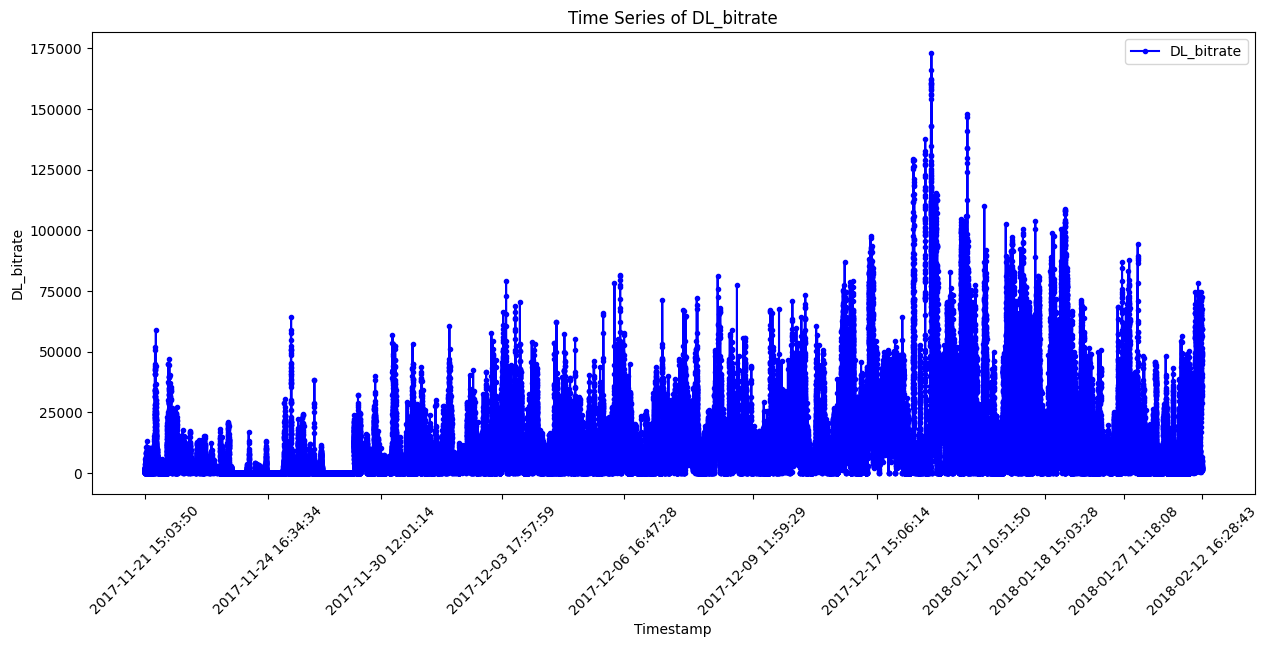

In [7]:
# Convert timestamps to string to use them as categorical values
combined_data['Timestamp'] = combined_data['Timestamp'].astype(str)

# Plot the time series treating Timestamp as categorical data
plt.figure(figsize=(15, 6))
plt.plot(combined_data['Timestamp'], combined_data['DL_bitrate'], marker='o', linestyle='-', markersize=3, color='blue', label="DL_bitrate")
plt.xlabel("Timestamp")
plt.ylabel("DL_bitrate")
plt.title("Time Series of DL_bitrate")

# Reduce the number of displayed ticks on the x-axis for readability
plt.xticks(ticks=combined_data['Timestamp'][::max(1, len(combined_data) // 10)], rotation=45)

plt.legend()
plt.show()

<Figure size 1000x800 with 0 Axes>

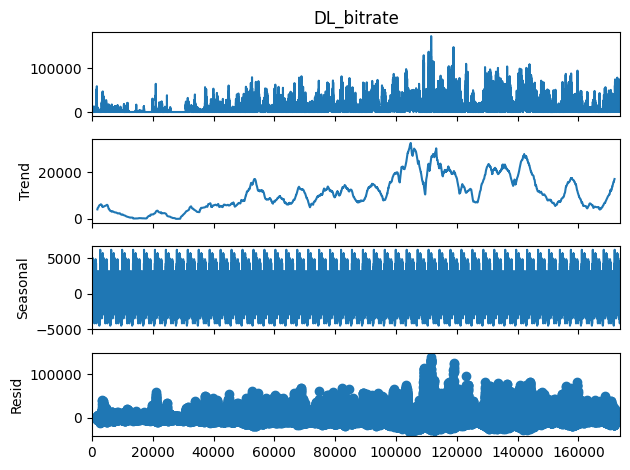

In [8]:
# Seasonal Decomposition
decomposition = seasonal_decompose(combined_data['DL_bitrate'], model='additive', period=3600)  # Use period=3600 for hourly seasonality

# Plot decomposition
plt.figure(figsize=(10, 8))
decomposition.plot()
plt.show()

**Check how target is related with the input features.**

<ipython-input-11-394c473d2229>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dl_bitrate_corr.index, y=dl_bitrate_corr.values, palette='viridis')


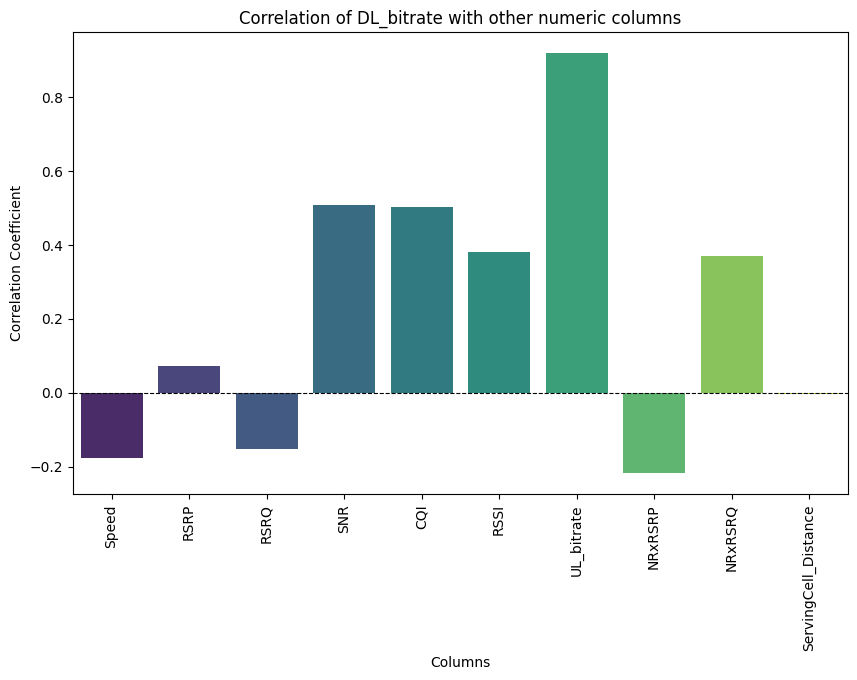

<ipython-input-11-394c473d2229>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_corr_df.index, y=category_corr_df['Correlation'], palette='magma')


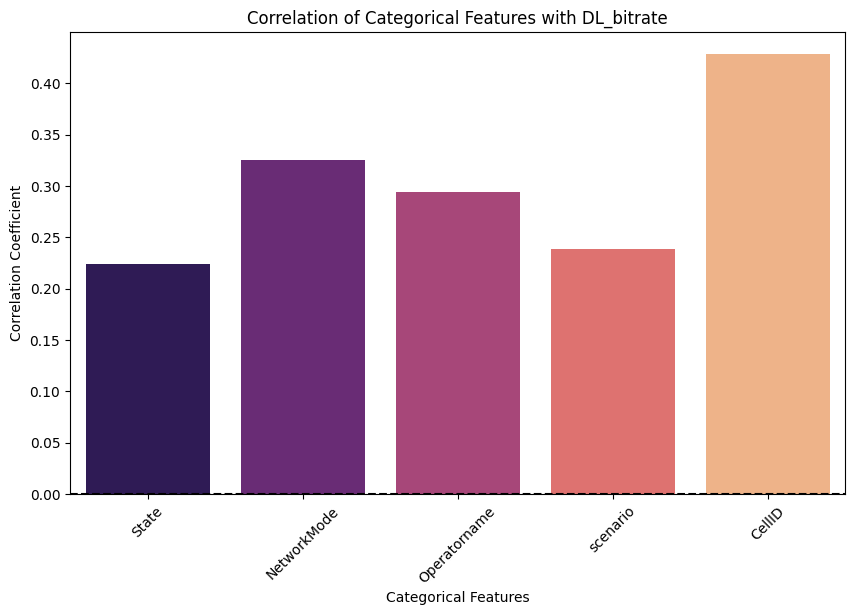

In [11]:
# Αφαίρεση μη αριθμητικών στηλών
non_numeric_columns = ['Timestamp', 'State', 'NetworkMode', 'Operatorname', 'CellID', 'scenario']
numeric_columns = [col for col in combined_data.columns if col not in non_numeric_columns]

# Υπολογισμός συντελεστών συσχέτισης
correlations = combined_data[numeric_columns].corr()

# Εστίαση στη συσχέτιση με τη στήλη DL_bitrate
dl_bitrate_corr = correlations['DL_bitrate'].drop('DL_bitrate')  # Αφαιρούμε τη συσχέτιση της στήλης με τον εαυτό της

# Οπτικοποίηση μέσω barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=dl_bitrate_corr.index, y=dl_bitrate_corr.values, palette='viridis')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title("Correlation of DL_bitrate with other numeric columns")
plt.xticks(rotation=90)
plt.ylabel("Correlation Coefficient")
plt.xlabel("Columns")
plt.show()

# Define categorical columns
categorical_columns = ['State', 'NetworkMode', 'Operatorname', 'scenario', 'CellID']

# Dictionary to store correlations
category_correlations = {}

# Compute correlation for each categorical variable
for cat_col in categorical_columns:
    # Convert categories into their mean DL_bitrate (Target Encoding)
    encoded_values = combined_data.groupby(cat_col)['DL_bitrate'].transform('mean')

    # Compute Pearson correlation between encoded values and target
    correlation = np.corrcoef(encoded_values, combined_data['DL_bitrate'])[0, 1]

    category_correlations[cat_col] = correlation

# Convert dictionary to DataFrame for visualization
category_corr_df = pd.DataFrame.from_dict(category_correlations, orient='index', columns=['Correlation'])

# Plot the categorical correlations as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=category_corr_df.index, y=category_corr_df['Correlation'], palette='magma')
plt.axhline(0, color='black', linestyle='--')
plt.title("Correlation of Categorical Features with DL_bitrate")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Categorical Features")
plt.xticks(rotation=45)
plt.show()

###**Numerical features**

**Replace NULL values with mean value of the numeric feature**

In [12]:
# Φόρτωση δεδομένων
df = pd.read_csv("combined_dataset.csv")

# Διόρθωση μορφής ημερομηνίας και μετατροπή σε datetime
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y.%m.%d %H.%M.%S", errors="coerce")

# Αντικατάσταση των NaN τιμών στις αριθμητικές στήλες με τον μέσο όρο τους
for column in numeric_columns:
    df[column] = df[column].fillna(df[column].mean())

In [13]:
df

,Timestamp,Speed,Operatorname,CellID,NetworkMode,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,NRxRSRP,NRxRSRQ,ServingCell_Distance,scenario
0,2018-02-05 15:07:31,14,B,4,LTE,-103,-12.0,9.0,15.0,-75.000000,32545,581,D,-81.007408,-19.123309,225.79000,train
1,2018-02-05 15:07:32,14,B,4,LTE,-92,-11.0,9.0,10.0,-79.911223,38148,695,D,-81.007408,-19.123309,225.79000,train
2,2018-02-05 15:07:32,23,B,4,LTE,-92,-11.0,9.0,10.0,-79.911223,38148,695,D,-81.007408,-19.123309,217.33000,train
3,2018-02-05 15:07:33,23,B,4,LTE,-92,-11.0,9.0,10.0,-79.911223,29973,552,D,-81.007408,-19.123309,217.33000,train
4,2018-02-05 15:07:34,23,B,4,LTE,-91,-12.0,12.0,10.0,-79.911223,43696,759,D,-81.007408,-19.123309,217.33000,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173687,2018-01-25 17:45:54,0,0,8,LTE,-200,-14.0,9.0,10.0,-79.911223,0,0,I,-81.007408,-19.123309,5637.70176,bus
173688,2018-01-25 17:45:55,0,0,8,LTE,-200,-14.0,9.0,10.0,-79.911223,0,0,I,-81.007408,-19.123309,5637.70176,bus
173689,2018-01-25 17:45:56,0,0,8,LTE,-200,-14.0,9.0,10.0,-79.911223,0,0,I,-81.007408,-19.123309,5637.70176,bus
173690,2018-01-25 17:45:57,0,0,8,LTE,-200,-14.0,9.0,10.0,-79.911223,0,0,I,-81.007408,-19.123309,5637.70176,bus


**Use Q-Q plots to check if numeric features follow Normal Distribution**

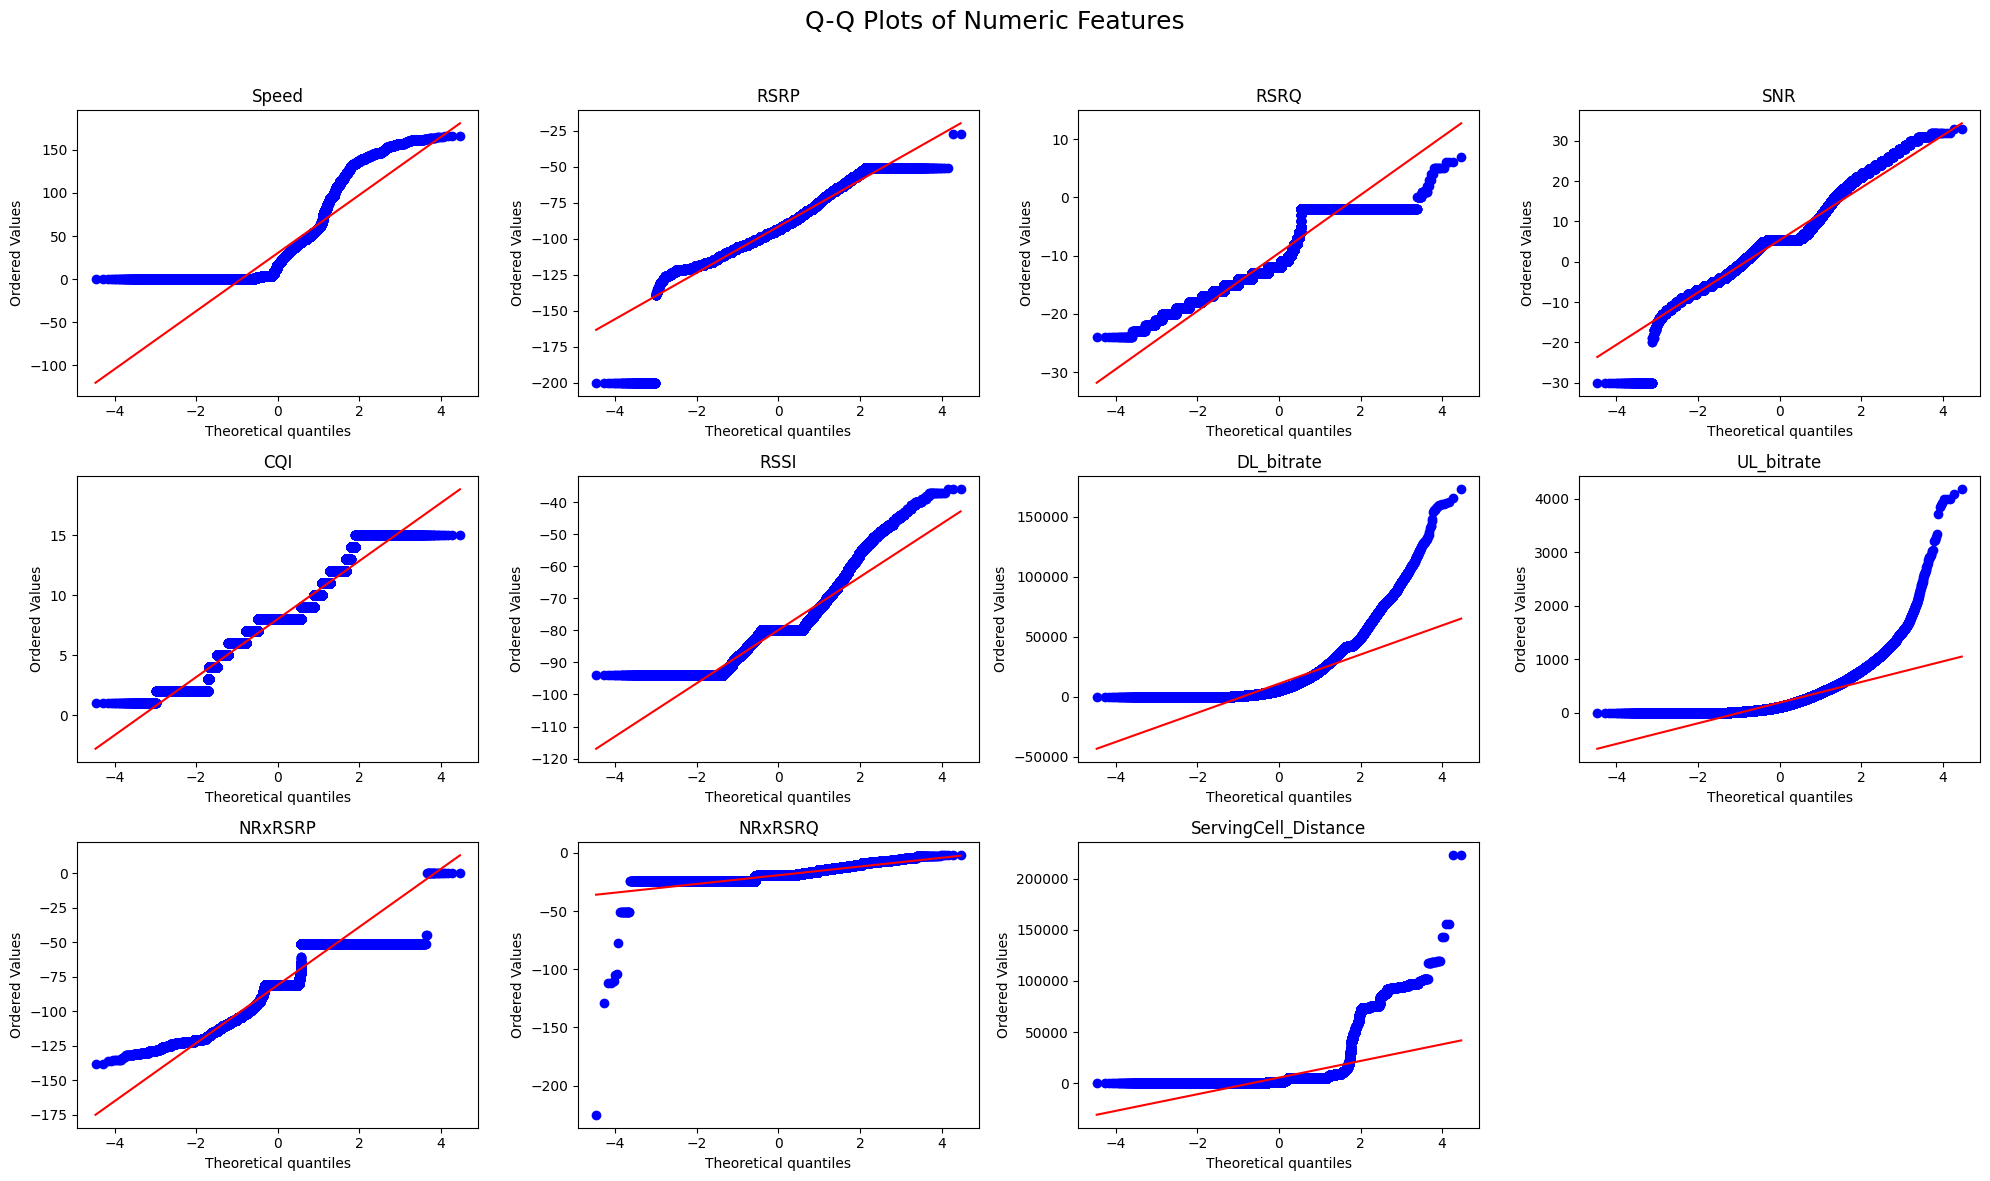

In [14]:
# Ορισμός των διαστάσεων του grid
cols = 4  # Κάθε σειρά έχει 4 plots
rows = math.ceil(len(numeric_columns) / cols)  # Υπολογισμός σειρών δυναμικά

# Δημιουργία figure και subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
fig.suptitle("Q-Q Plots of Numeric Features", fontsize=18)

# Flatten για εύκολη διαχείριση
axes = axes.flatten()

# Σχεδίαση Q-Q plots για κάθε χαρακτηριστικό
for i, column in enumerate(numeric_columns):
    stats.probplot(df[column].dropna(), dist="norm", plot=axes[i])
    axes[i].set_title(f'{column}')

# Αφαίρεση κενών subplots αν υπάρχουν
for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

# Προσαρμογή layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Since most features don't follow Normal Distribution, we detect the outliers using the IQR Method and apply capping to correct them.**

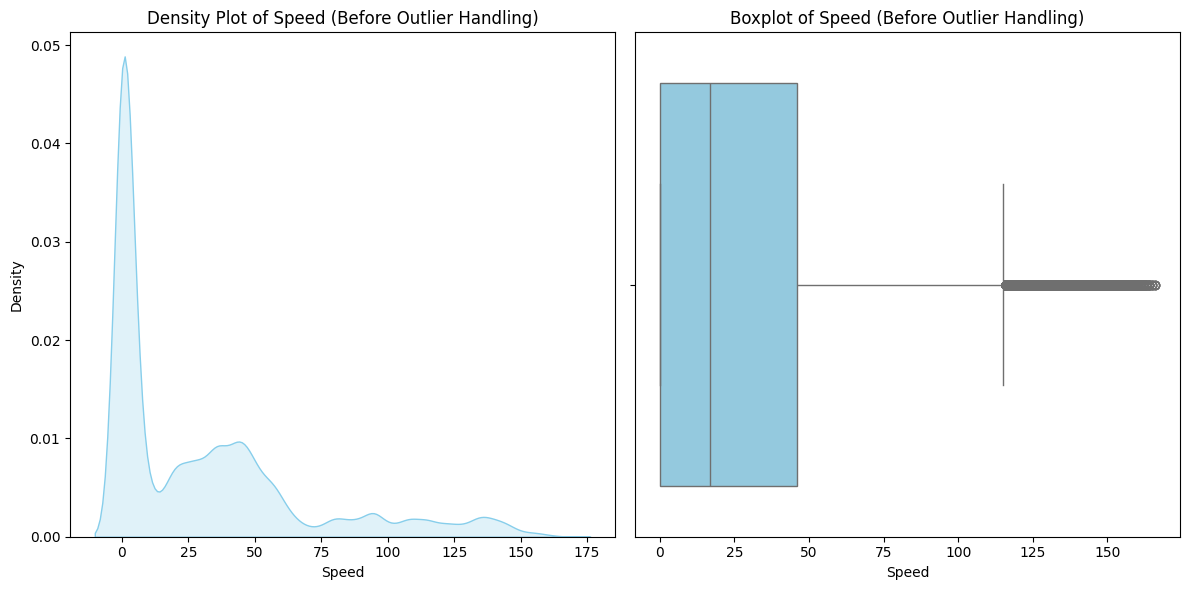

For column Speed:
Q1 = 0.0, Q3 = 46.0, IQR = 46.0
Lower Bound = -69.0, Upper Bound = 115.0
Number of Outliers: 9520



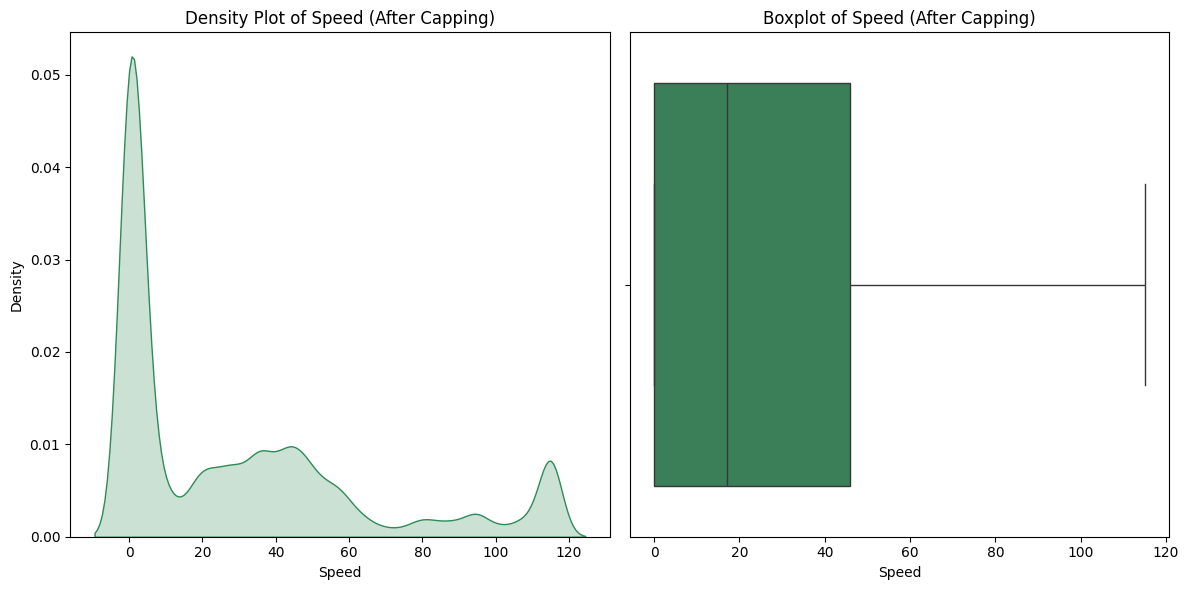

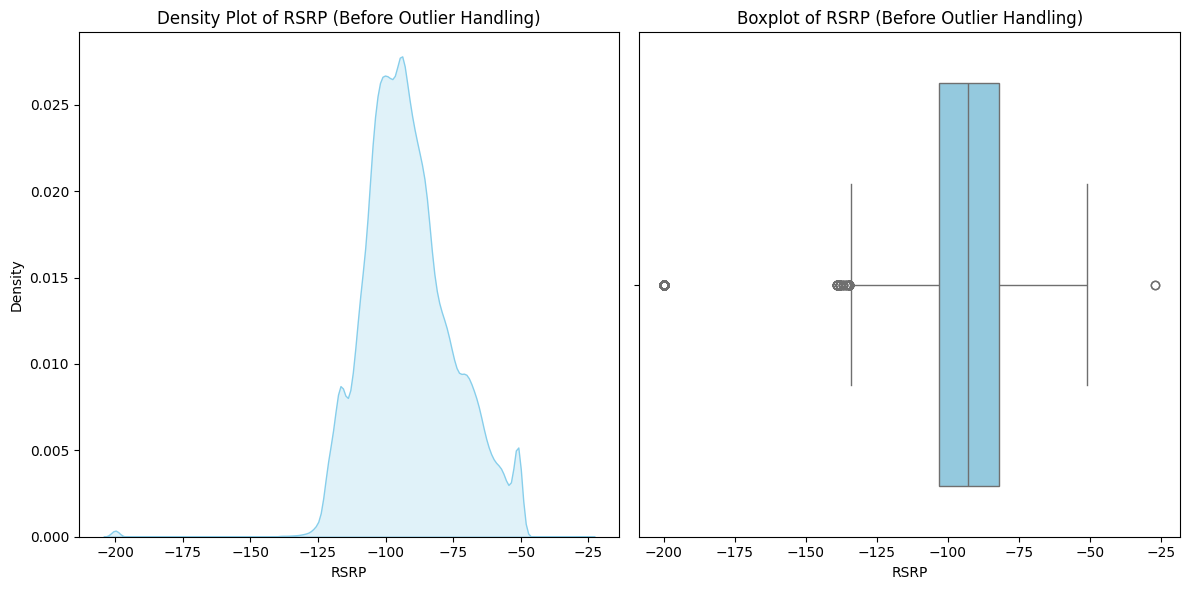

For column RSRP:
Q1 = -103.0, Q3 = -82.0, IQR = 21.0
Lower Bound = -134.5, Upper Bound = -50.5
Number of Outliers: 288



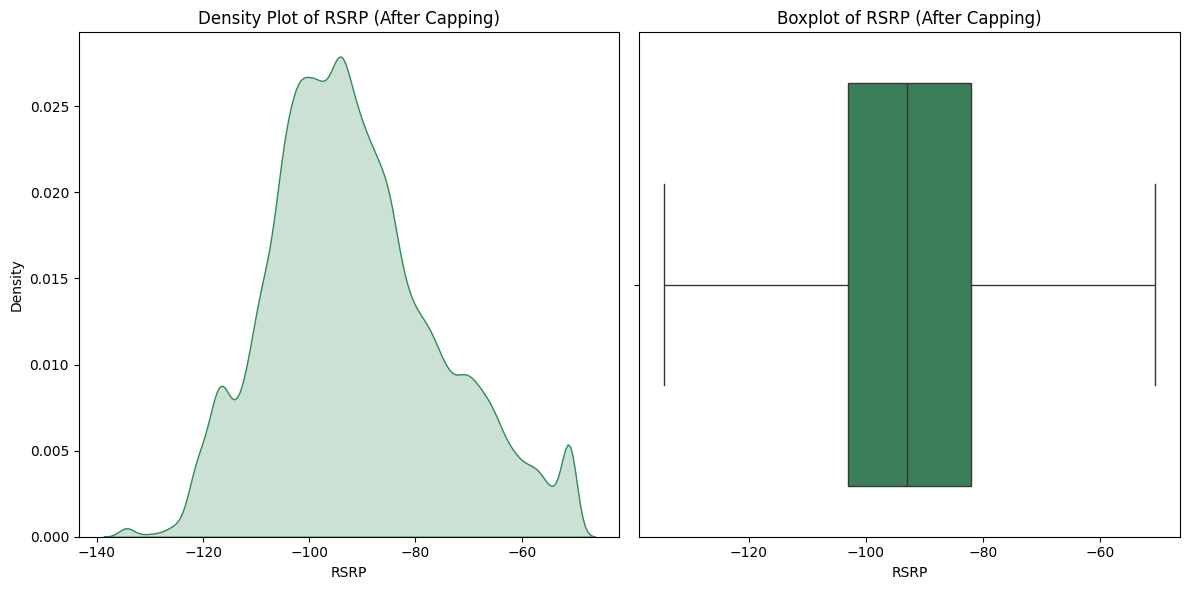

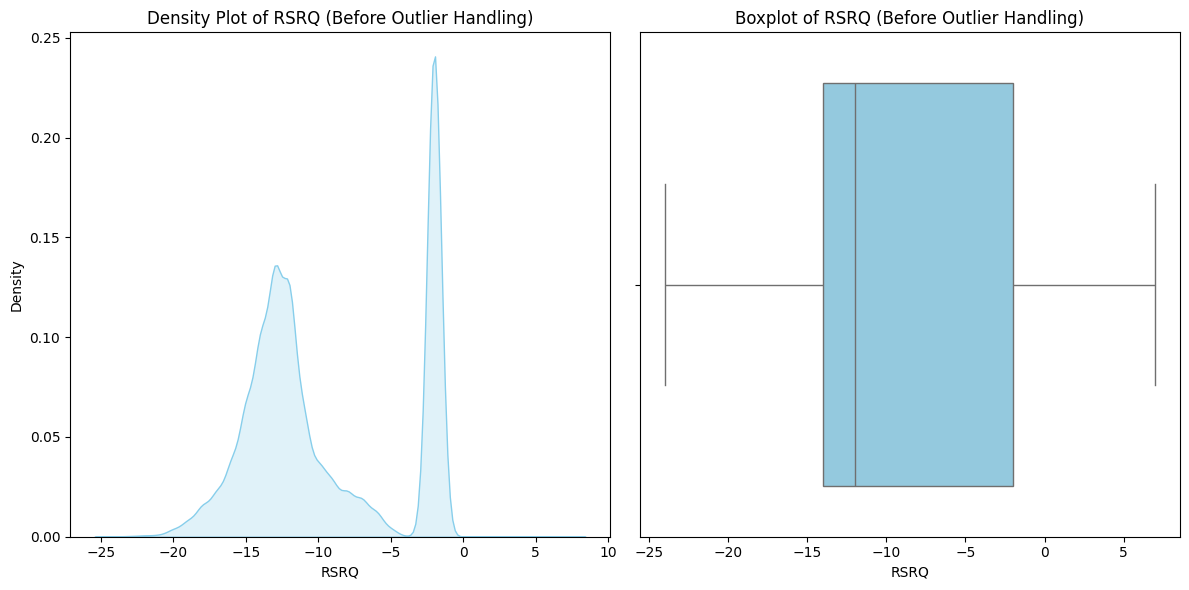

For column RSRQ:
Q1 = -14.0, Q3 = -2.0, IQR = 12.0
Lower Bound = -32.0, Upper Bound = 16.0
Number of Outliers: 0



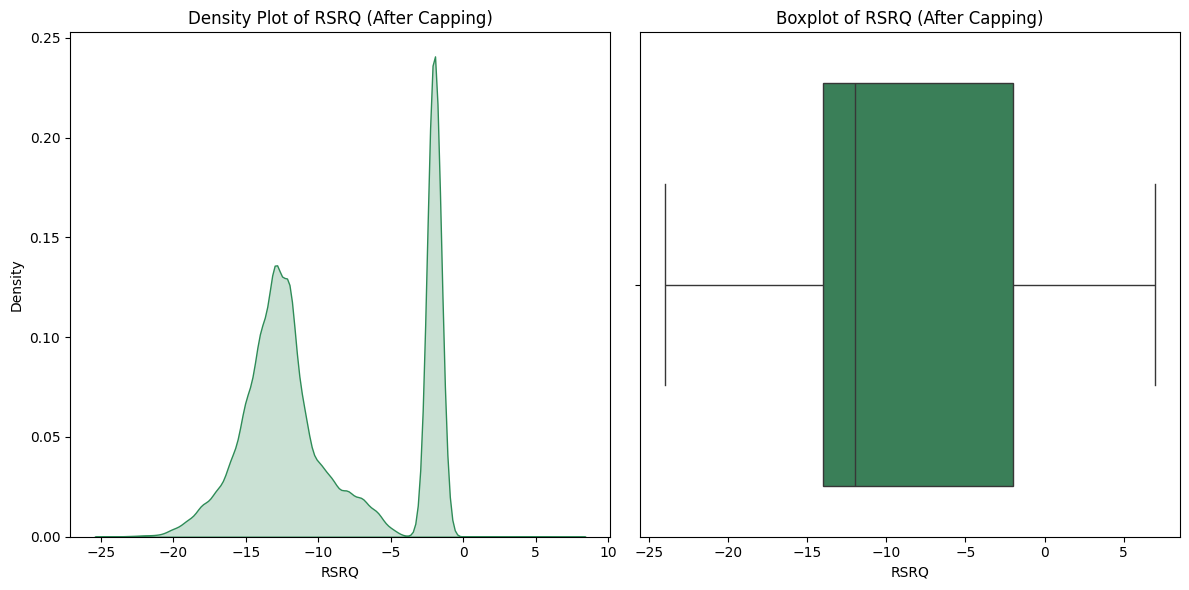

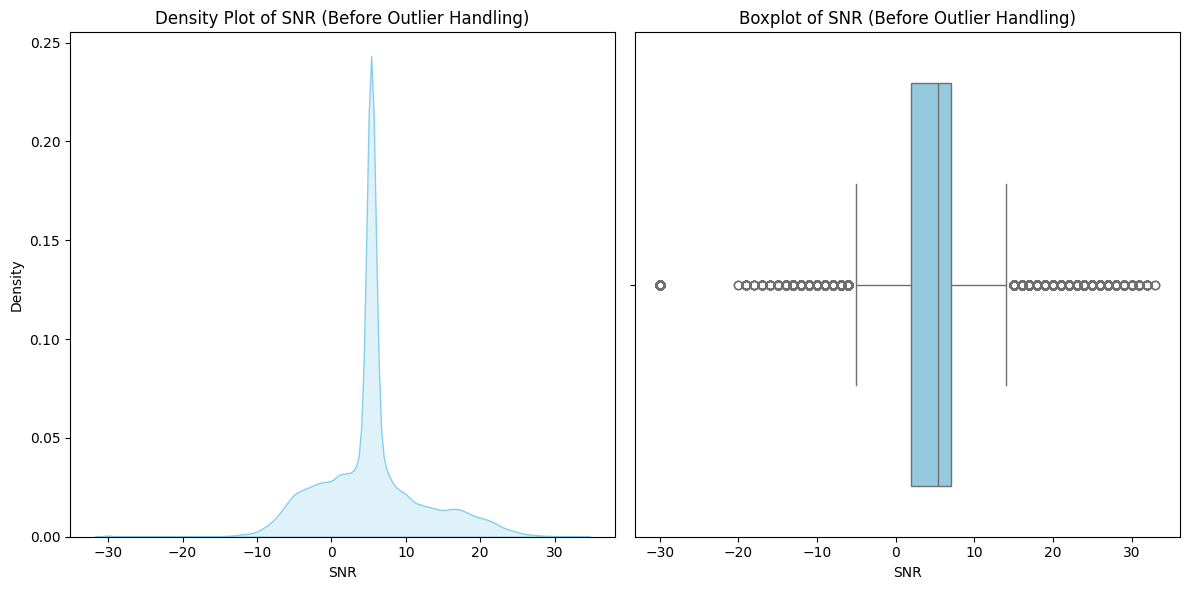

For column SNR:
Q1 = 2.0, Q3 = 7.0, IQR = 5.0
Lower Bound = -5.5, Upper Bound = 14.5
Number of Outliers: 26547



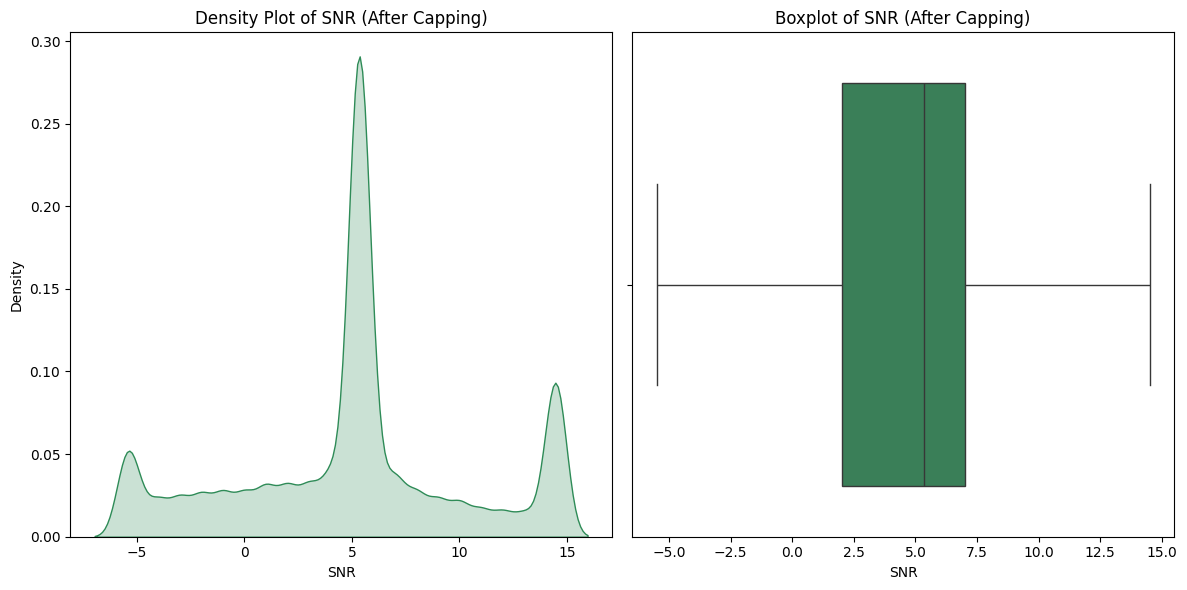

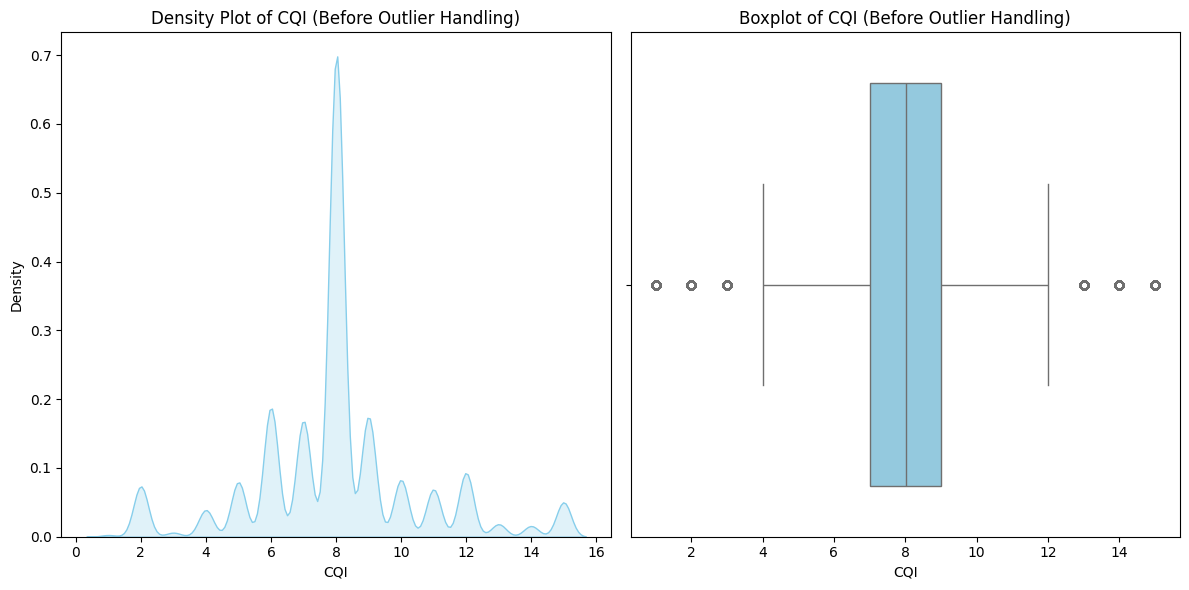

For column CQI:
Q1 = 7.0, Q3 = 9.0, IQR = 2.0
Lower Bound = 4.0, Upper Bound = 12.0
Number of Outliers: 16334



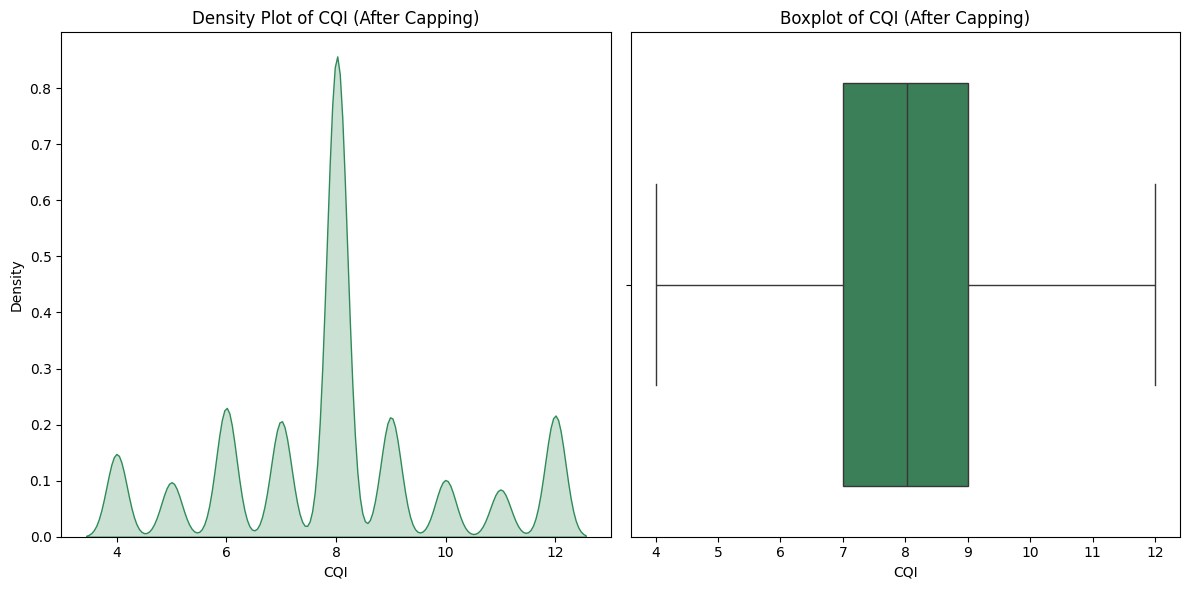

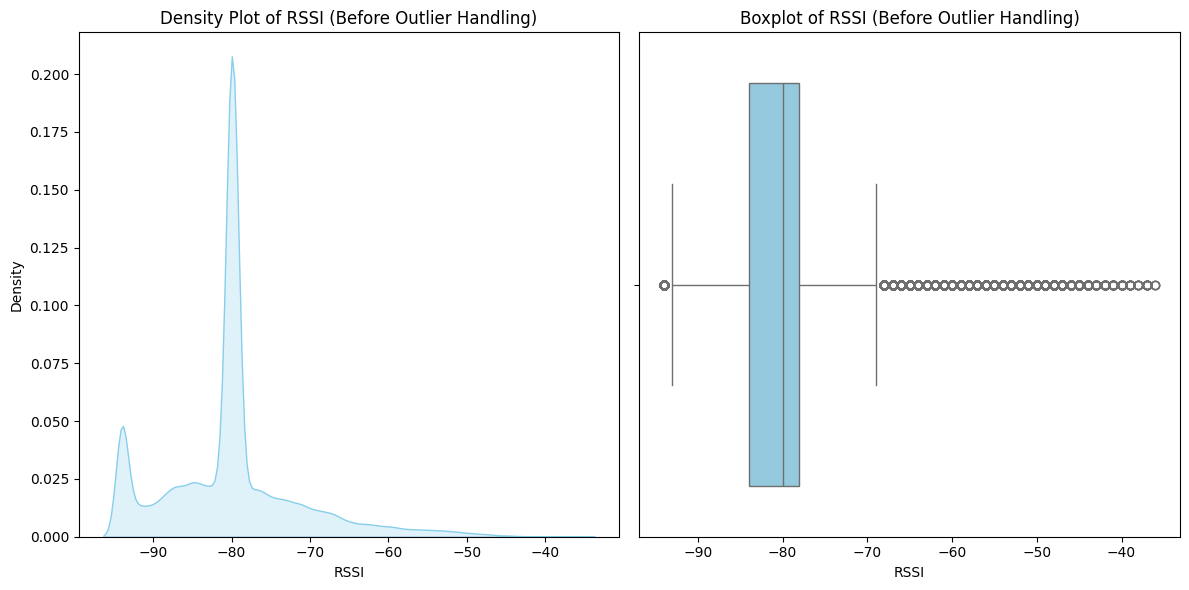

For column RSSI:
Q1 = -84.0, Q3 = -78.0, IQR = 6.0
Lower Bound = -93.0, Upper Bound = -69.0
Number of Outliers: 32004



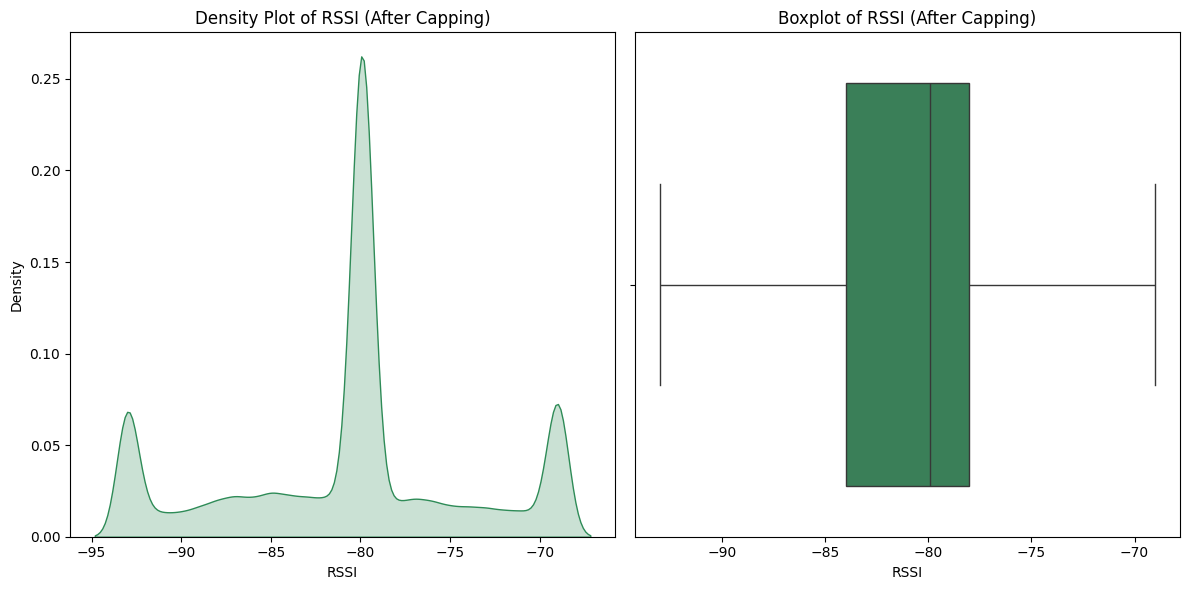

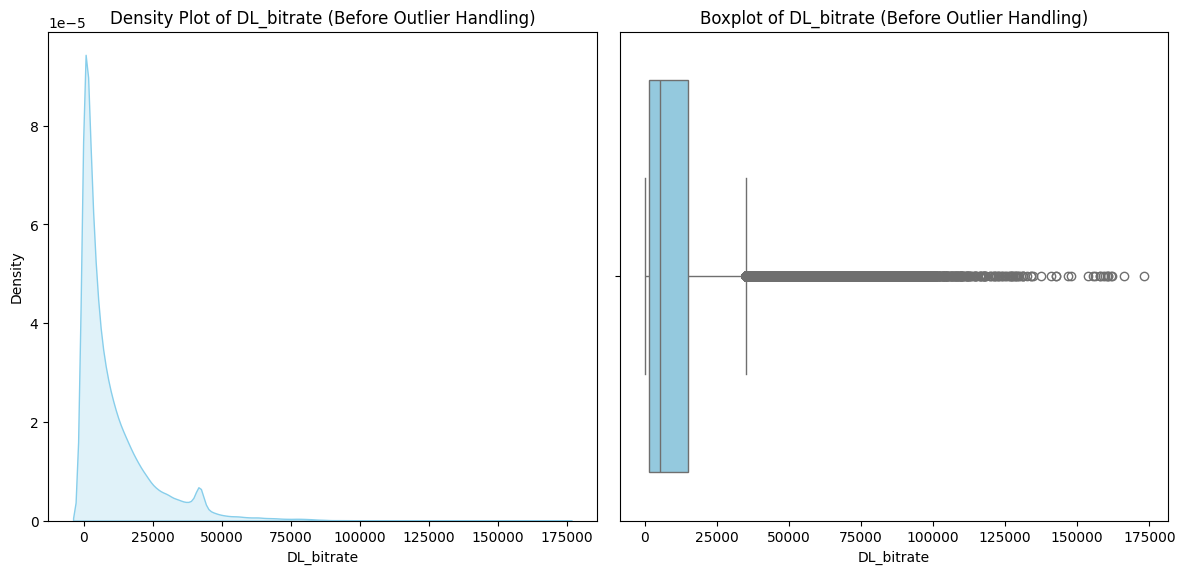

For column DL_bitrate:
Q1 = 1420.0, Q3 = 14841.0, IQR = 13421.0
Lower Bound = -18711.5, Upper Bound = 34972.5
Number of Outliers: 13177



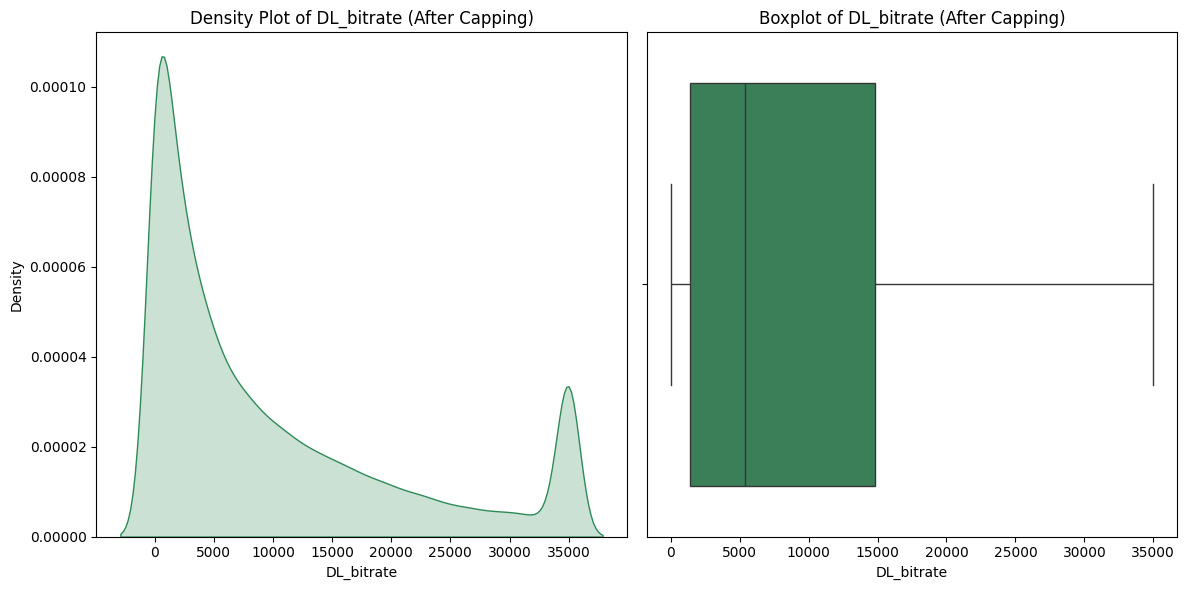

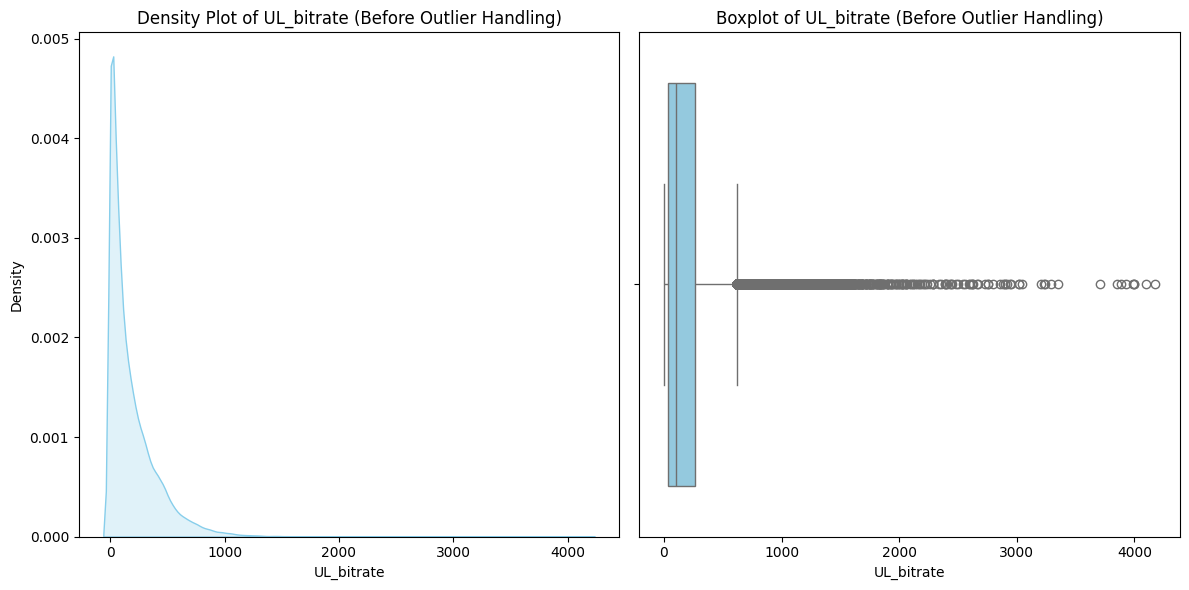

For column UL_bitrate:
Q1 = 32.0, Q3 = 267.0, IQR = 235.0
Lower Bound = -320.5, Upper Bound = 619.5
Number of Outliers: 8533



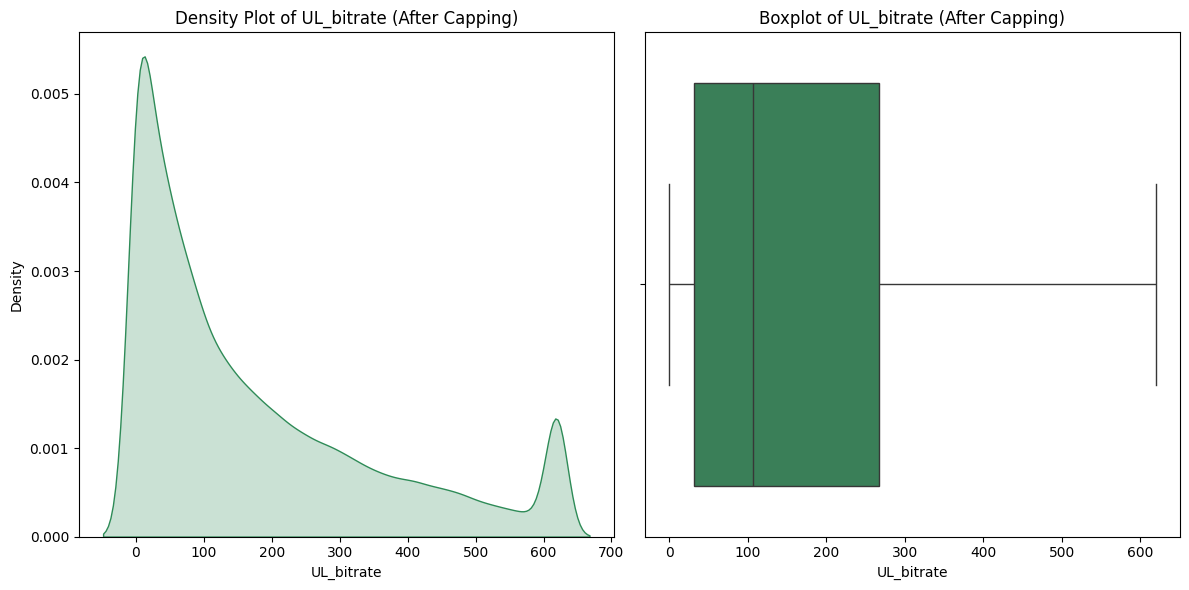

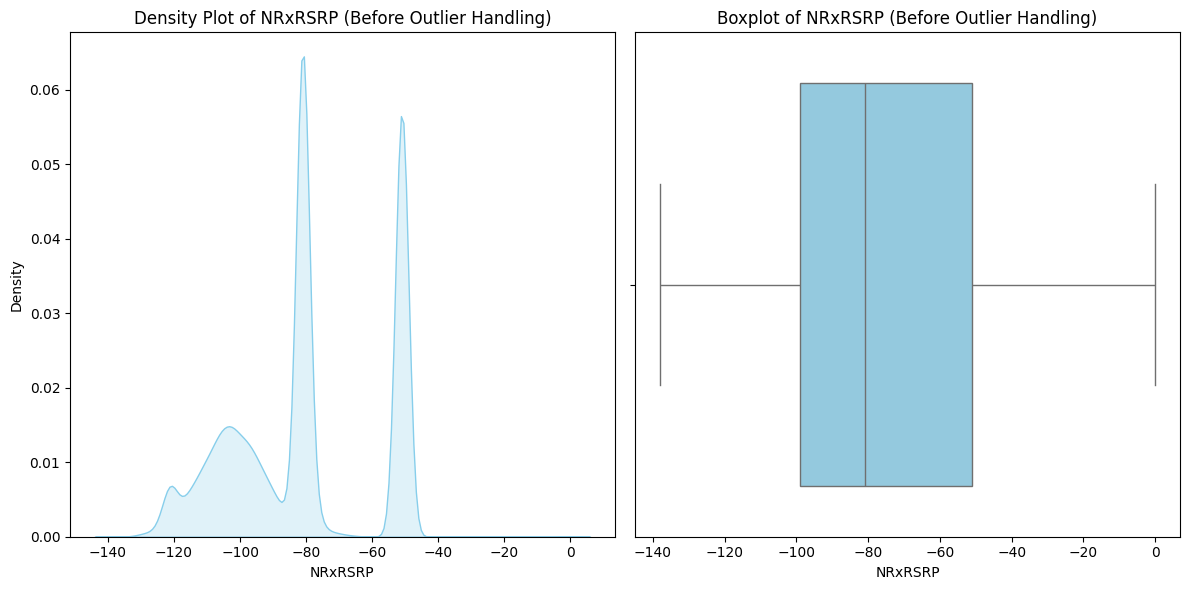

For column NRxRSRP:
Q1 = -99.0, Q3 = -51.0, IQR = 48.0
Lower Bound = -171.0, Upper Bound = 21.0
Number of Outliers: 0



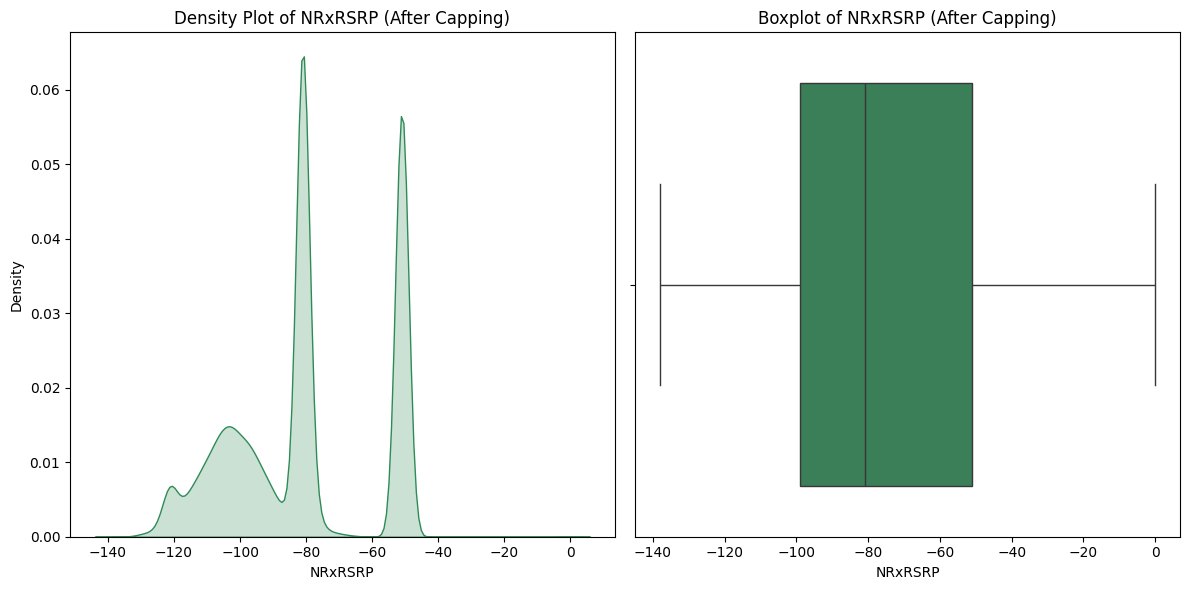

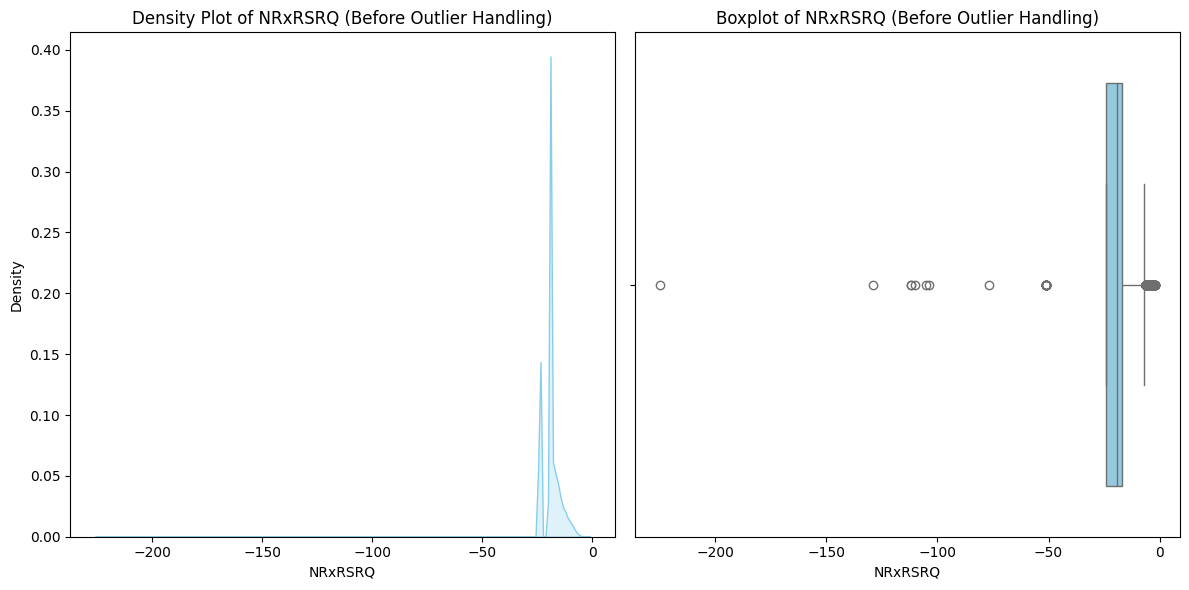

For column NRxRSRQ:
Q1 = -24.0, Q3 = -17.0, IQR = 7.0
Lower Bound = -34.5, Upper Bound = -6.5
Number of Outliers: 535



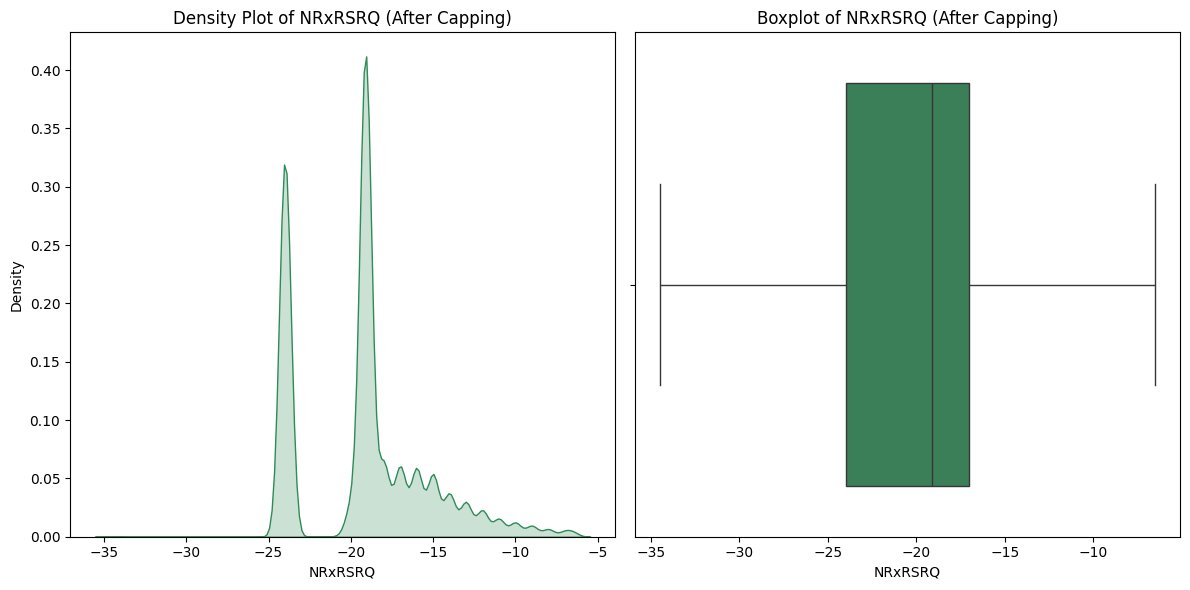

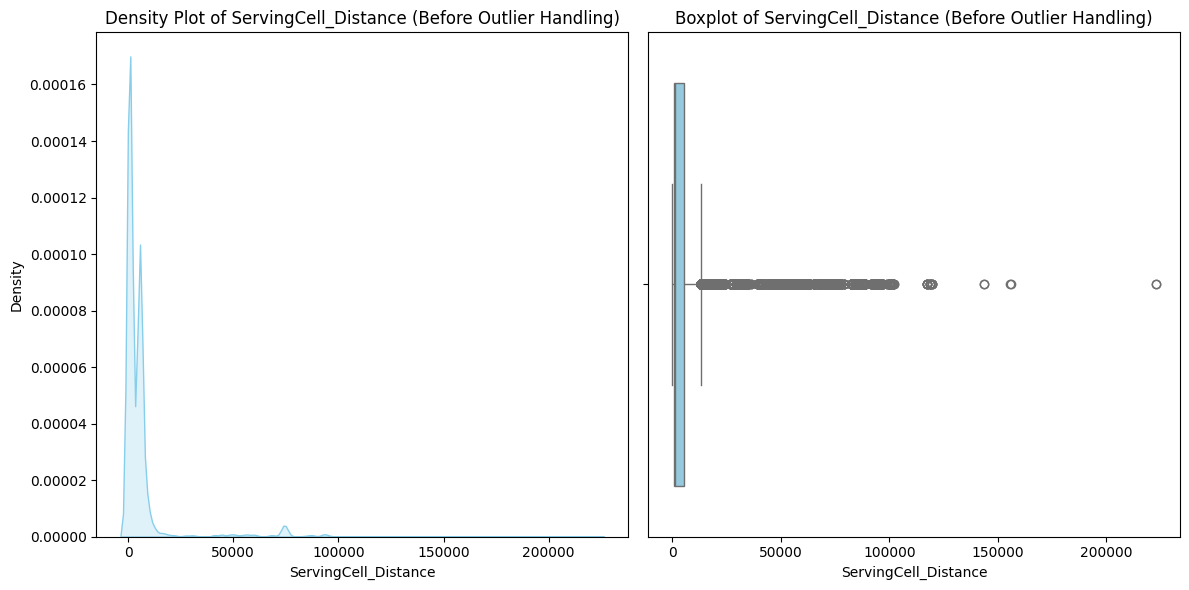

For column ServingCell_Distance:
Q1 = 595.84, Q3 = 5637.701759642765, IQR = 5041.861759642765
Lower Bound = -6966.952639464147, Upper Bound = 13200.494399106912
Number of Outliers: 8879



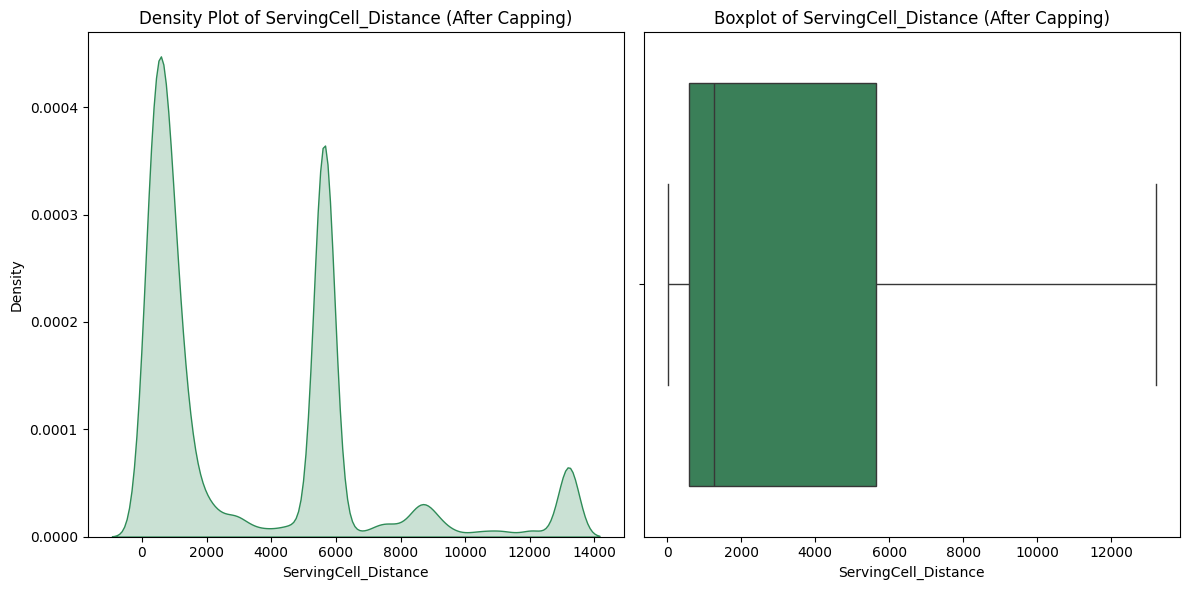

In [15]:
# Εξερεύνηση δεδομένων ανά χαρακτηριστικό
for column in numeric_columns:
    plt.figure(figsize=(12, 6))

    # Density Plot πριν τον χειρισμό των outliers
    plt.subplot(1, 2, 1)
    sns.kdeplot(df[column], fill=True, color="skyblue")
    plt.title(f'Density Plot of {column} (Before Outlier Handling)')
    plt.xlabel(column)

    # Boxplot πριν τον χειρισμό των outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column], color="skyblue")
    plt.title(f'Boxplot of {column} (Before Outlier Handling)')
    plt.xlabel(column)

    plt.tight_layout()
    plt.show()

    # Εντοπισμός outliers βάσει IQR
    Q1 = np.percentile(df[column].dropna(), 25)
    Q3 = np.percentile(df[column].dropna(), 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR  # Χρησιμοποιούμε 1.5 * IQR (ή 3 * IQR αν θέλεις πιο αυστηρό φιλτράρισμα)
    upper_bound = Q3 + 1.5 * IQR

    print(f"For column {column}:")
    print(f"Q1 = {Q1}, Q3 = {Q3}, IQR = {IQR}")
    print(f"Lower Bound = {lower_bound}, Upper Bound = {upper_bound}")
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Number of Outliers: {len(outliers)}")
    print()

    # **Capping των outliers αντί να τα αφαιρούμε**
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

    # Density Plot και Boxplot μετά το capping
    plt.figure(figsize=(12, 6))

    # Density Plot μετά τον χειρισμό των outliers
    plt.subplot(1, 2, 1)
    sns.kdeplot(df[column], fill=True, color="seagreen")
    plt.title(f'Density Plot of {column} (After Capping)')
    plt.xlabel(column)

    # Boxplot μετά το capping
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column], color="seagreen")
    plt.title(f'Boxplot of {column} (After Capping)')
    plt.xlabel(column)

    plt.tight_layout()
    plt.show()

**Finally, apply Z-Score Normalization since the numeric features are measured in different units.**

In [ ]:
"""for column in numeric_columns:
    mean_value = df[column].mean()
    std_value = df[column].std()
    df[column] = (df[column] - mean_value) / std_value"""

In [ ]:
df

,Timestamp,Speed,Operatorname,CellID,NetworkMode,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,NRxRSRP,NRxRSRQ,ServingCell_Distance,scenario
0,2017-11-24 14:34:43,-0.831615,A,1,LTE,0.215680,-0.453619,1.751284,0.967794,1.417994,-0.903544,-0.769656,D,-1.275175e-15,-0.000262,-0.852033,train
1,2017-11-24 14:34:44,-0.774584,A,1,LTE,0.215680,-0.453619,0.551700,0.483877,1.123116,-0.903544,-0.769656,D,-1.275175e-15,-0.000262,-0.856958,train
2,2017-11-24 14:34:45,-0.774584,A,1,LTE,0.215680,-0.453619,1.751284,0.967794,1.417994,-0.892058,-0.937115,D,-1.275175e-15,-0.000262,-0.856958,train
3,2017-11-24 14:34:46,-0.774584,A,1,LTE,0.403984,-0.453619,1.751284,0.967794,1.712873,-0.908082,-0.970607,I,-1.275175e-15,-0.000262,-0.856958,train
4,2017-11-24 14:34:47,-0.774584,A,1,LTE,0.403984,-0.453619,1.751284,0.967794,0.828238,-0.908082,-0.970607,I,-1.275175e-15,-0.000262,-0.856958,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173687,2018-01-27 11:22:32,-0.803099,A,1,LTE,0.152911,-0.083000,-1.939744,-1.935703,1.270555,-0.252379,-0.334260,D,-5.829285e-01,1.300667,-0.726579,bus
173688,2018-01-27 11:22:34,-0.803099,A,1,LTE,0.152911,-0.083000,-1.939744,-1.935703,1.270555,-0.027575,-0.323096,D,-1.275175e-15,-0.000262,-0.726579,bus
173689,2018-01-27 11:22:34,-0.803099,A,1,LTE,0.215680,-0.824237,-1.478365,-1.935703,1.270555,0.329871,0.112299,D,-4.931961e-01,0.538896,-0.726579,bus
173690,2018-01-27 11:22:36,-0.803099,A,1,LTE,0.215680,-0.824237,-1.478365,-1.935703,1.270555,0.502804,0.062061,D,-4.931961e-01,0.538896,-0.726579,bus


**Finally, we compute the correlation matrix to see how the numerical features are related.**

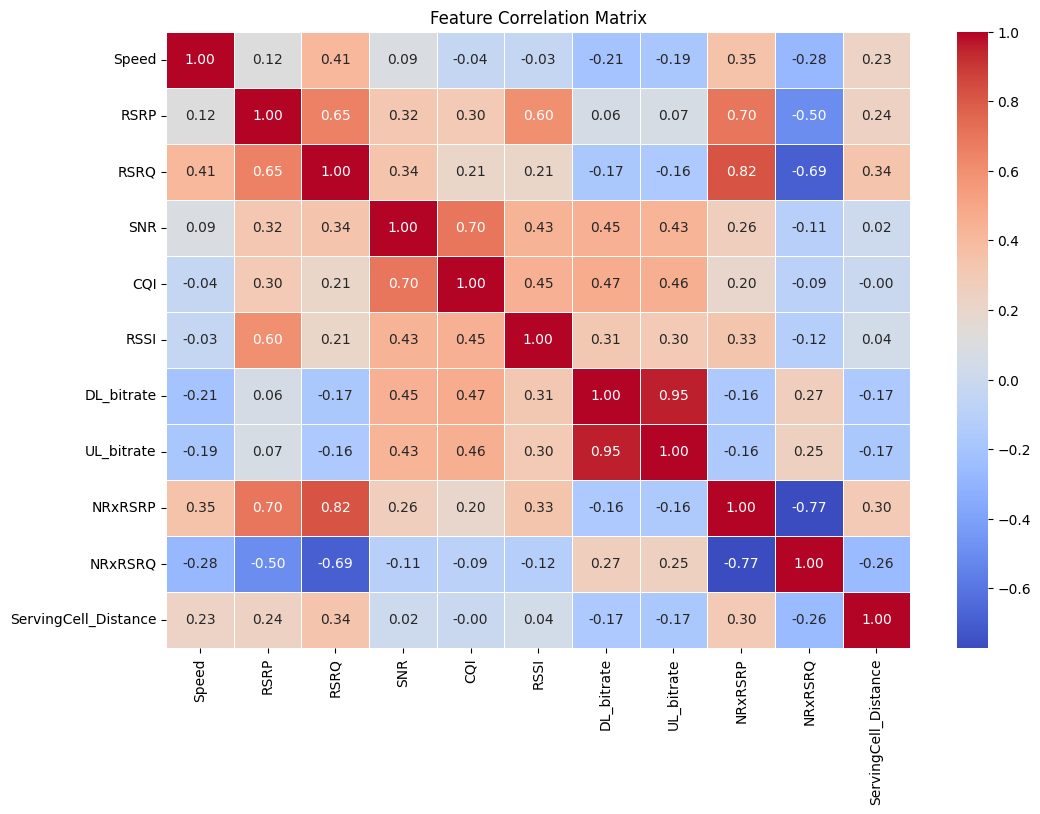

In [16]:
# Compute the correlation matrix
correlation_matrix = df[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

###**Categorical features**

**We combine all the categorical features in one numerical feature called "Categorical_Impact" using the principal component with the biggest variance from PCA Analysis.**

In [17]:
# Κατηγορικά χαρακτηριστικά προς κωδικοποίηση
categorical_features = ["State", "NetworkMode", "Operatorname", "CellID", "scenario"]

# One-Hot Encoding των κατηγορικών χαρακτηριστικών
encoder = OneHotEncoder(drop='first')
encoded_cats = encoder.fit_transform(df[categorical_features])

# PCA για μείωση διαστάσεων
pca = PCA(n_components=1)  # Κρατάμε μόνο το κύριο component με το μεγαλυτερο variance
categorical_pca_feature = pca.fit_transform(encoded_cats)

# Προσθήκη του νέου feature στο dataframe
df["Categorical_Impact"] = categorical_pca_feature

# Αφαίρεση των αρχικών κατηγορικών χαρακτηριστικών
df.drop(columns=categorical_features, inplace=True)

# Αφαίρεση και των ημερομηνιών που δεν χρειάζονται πλέον
df.drop(columns=["Timestamp"], inplace=True)

In [18]:
df

,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,NRxRSRP,NRxRSRQ,ServingCell_Distance,Categorical_Impact
0,14.0,-103.0,-12.0,9.0,12.0,-75.000000,32545.0,581.0,-81.007408,-19.123309,225.79000,-0.009769
1,14.0,-92.0,-11.0,9.0,10.0,-79.911223,34972.5,619.5,-81.007408,-19.123309,225.79000,-0.009769
2,23.0,-92.0,-11.0,9.0,10.0,-79.911223,34972.5,619.5,-81.007408,-19.123309,217.33000,-0.009769
3,23.0,-92.0,-11.0,9.0,10.0,-79.911223,29973.0,552.0,-81.007408,-19.123309,217.33000,-0.009769
4,23.0,-91.0,-12.0,12.0,10.0,-79.911223,34972.5,619.5,-81.007408,-19.123309,217.33000,-0.009769
...,...,...,...,...,...,...,...,...,...,...,...,...
173687,0.0,-134.5,-14.0,9.0,10.0,-79.911223,0.0,0.0,-81.007408,-19.123309,5637.70176,0.069831
173688,0.0,-134.5,-14.0,9.0,10.0,-79.911223,0.0,0.0,-81.007408,-19.123309,5637.70176,0.069831
173689,0.0,-134.5,-14.0,9.0,10.0,-79.911223,0.0,0.0,-81.007408,-19.123309,5637.70176,0.069831
173690,0.0,-134.5,-14.0,9.0,10.0,-79.911223,0.0,0.0,-81.007408,-19.123309,5637.70176,0.069831


In [21]:
# Αποθήκευση του τελικού επεξεργασμένου dataset
df.to_csv("drive/MyDrive/final_dataset.csv", index=False)

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

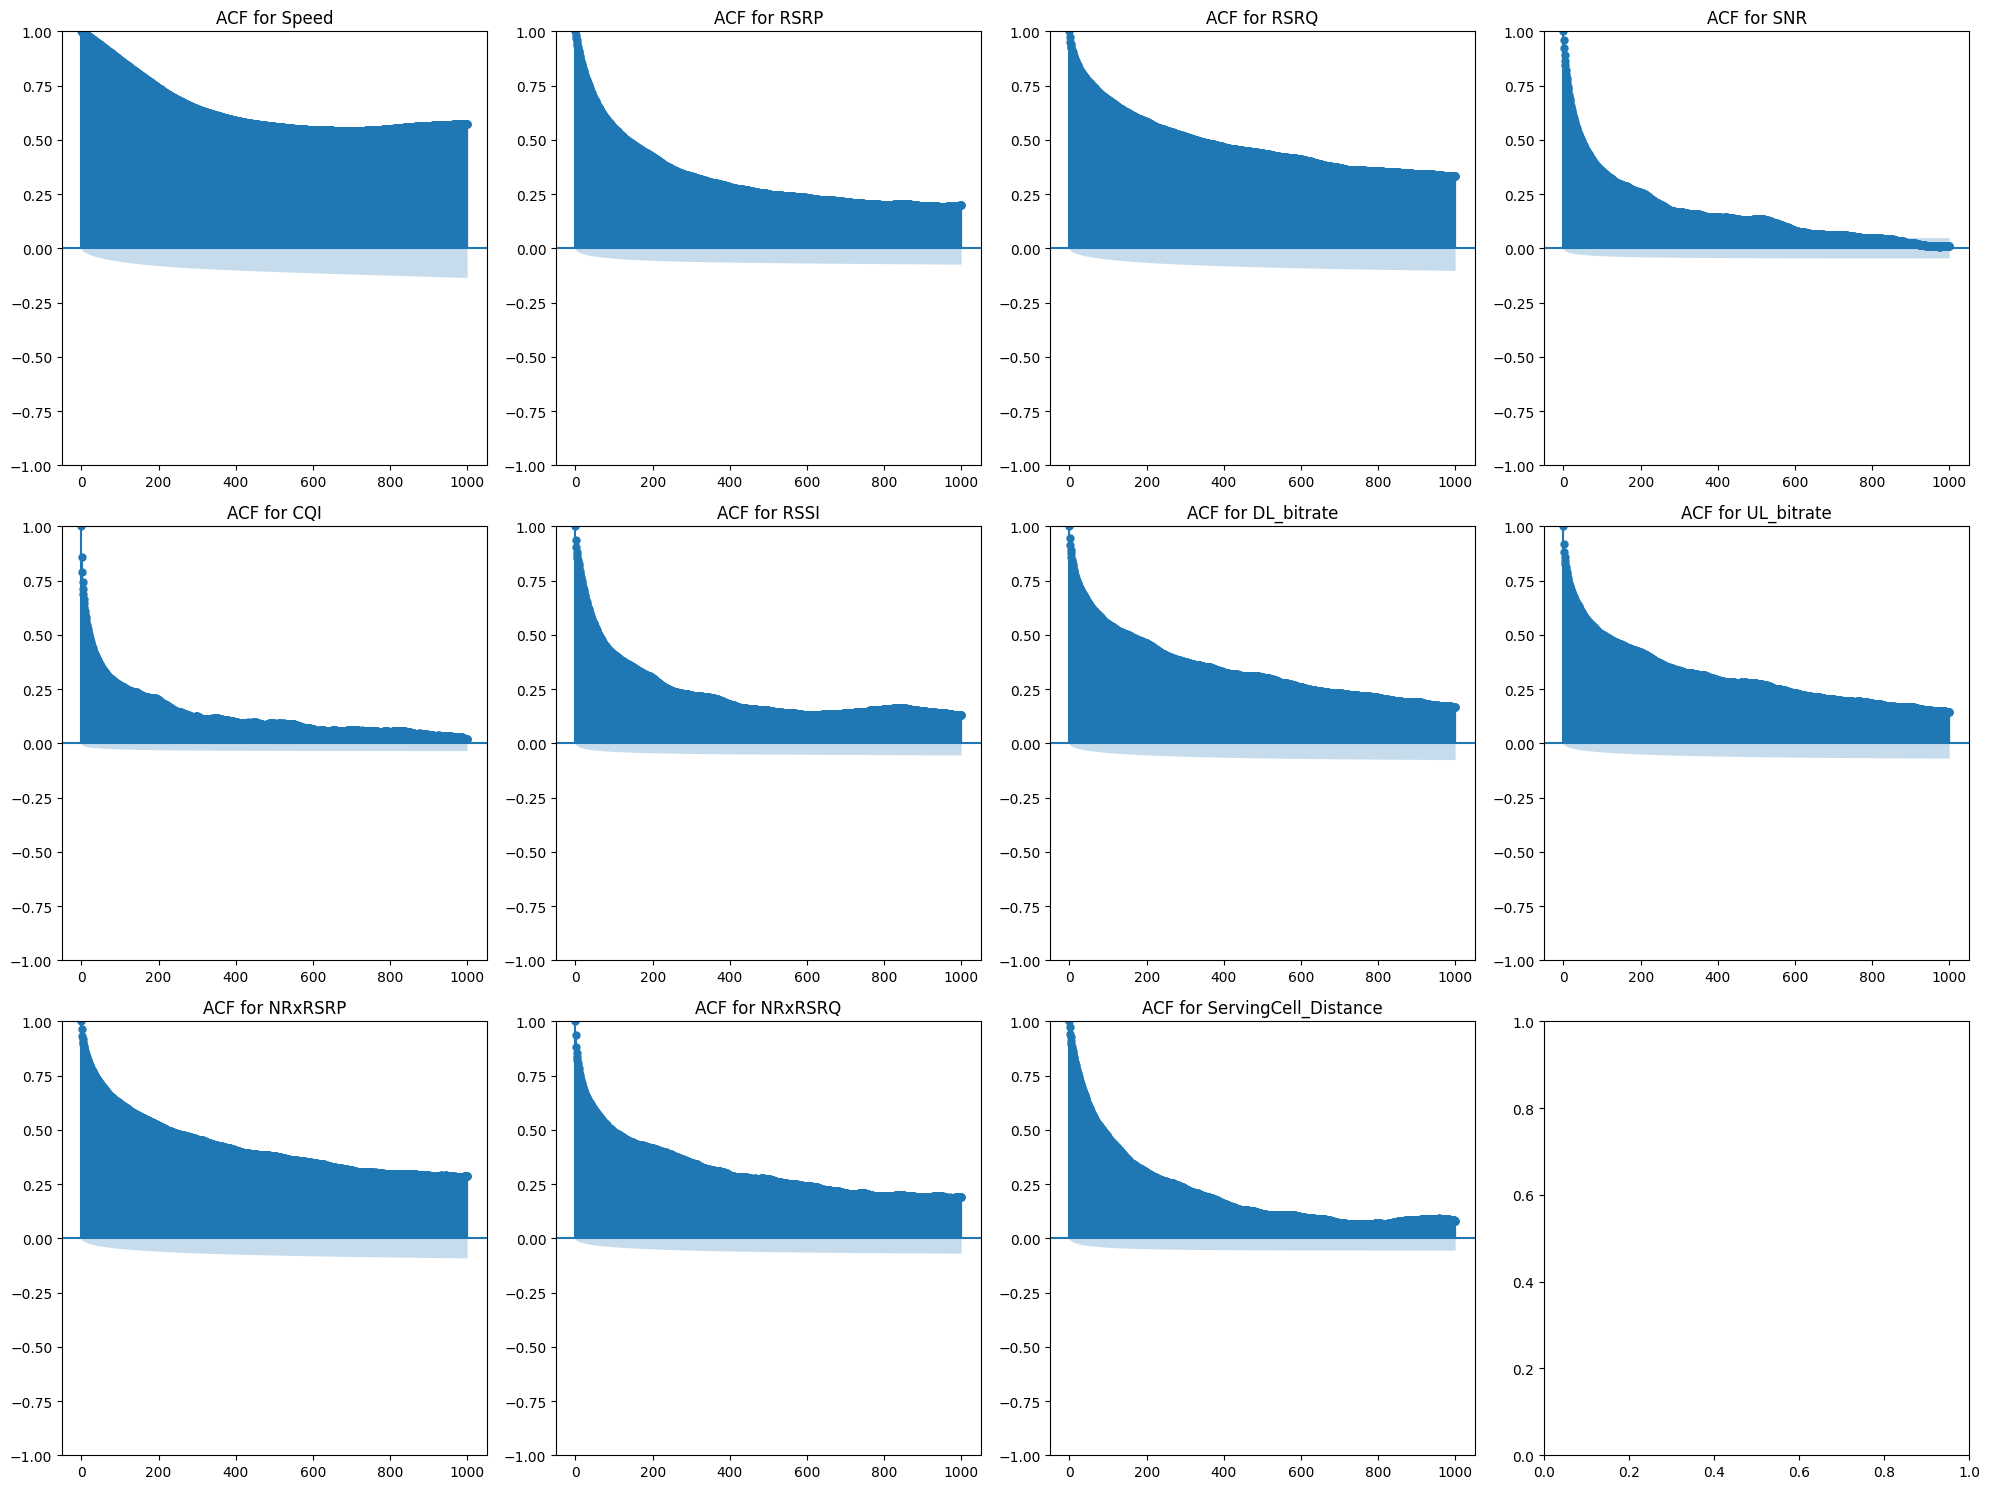

In [22]:
# Επιλογή όλων των αριθμητικών στηλών
features = ['Speed', 'RSRP', 'RSRQ', 'SNR', 'CQI', 'RSSI',
       'DL_bitrate', 'UL_bitrate', 'NRxRSRP', 'NRxRSRQ',
       'ServingCell_Distance', 'Categorical_Impact']

# Υπολογισμός και σχεδίαση ACF για κάθε αριθμητικό χαρακτηριστικό
rows, cols = 3, 4
num_features = len(features)
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

# Σχεδίαση των ACF plots
for i, column in enumerate(numeric_columns):
    row, col = divmod(i, cols)  # Υπολογισμός της θέσης στο grid
    sm.graphics.tsa.plot_acf(df[column].dropna(), lags=1000, alpha=0.05, ax=axes[row, col]) # 1000 seconds
    axes[row, col].set_title(f"ACF for {column}")

plt.tight_layout()
plt.show()

**We choose to create lags organized in frames of 100 secs each.**

In [ ]:
# Ορισμός διαστήματος καθυστέρησης (lag interval)
lag_interval = 100  # Δημιουργία lags ανά 100 δευτερόλεπτα

# Δημιουργία νέων στηλών με τα lags
for feature in features:
    for lag in range(lag_interval, lag_interval * 5 + 1, lag_interval):  # Δημιουργούμε 5 διαφορετικά lags
        df[f"{feature}_lag_{lag}"] = df[feature].shift(lag)

# Αφαίρεση των αρχικών γραμμών που περιέχουν NaN λόγω των lags
df = df.dropna()

In [ ]:
df

,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,NRxRSRP,NRxRSRQ,...,ServingCell_Distance_lag_100,ServingCell_Distance_lag_200,ServingCell_Distance_lag_300,ServingCell_Distance_lag_400,ServingCell_Distance_lag_500,Categorical_Impact_lag_100,Categorical_Impact_lag_200,Categorical_Impact_lag_300,Categorical_Impact_lag_400,Categorical_Impact_lag_500
500,-0.774584,0.152911,-0.638928,0.920803,1.935626,1.270555,-0.797301,-0.741746,-1.275175e-15,-0.000262,...,-0.913114,-0.890458,-0.858296,-0.421987,-0.807820,0.664633,0.664633,0.664633,0.265154,0.664633
501,-0.774584,-0.349234,-0.824237,0.367149,-0.967871,0.091042,-0.844911,-0.903624,-1.275175e-15,-0.000262,...,-0.913114,-0.890458,-0.858296,0.622095,-0.807820,0.664633,0.664633,0.664633,0.265154,0.536313
502,-0.774584,-0.349234,-0.824237,0.367149,-0.967871,0.091042,-0.885296,-0.909206,-1.275175e-15,-0.000262,...,-0.913114,-0.890458,-0.858296,0.622095,-0.807241,0.664633,0.664633,0.664633,0.265154,0.536313
503,-0.774584,-0.788612,-0.824237,-0.740160,-0.483955,-0.941032,-0.820087,-0.836640,-1.275175e-15,-0.000262,...,-0.914556,-0.893423,-0.858296,-0.828713,-0.804415,0.664633,0.664633,0.664633,0.664633,0.536313
504,-0.746068,-0.788612,-0.824237,-0.740160,1.451710,0.091042,-0.766178,-0.725000,-1.275175e-15,-0.000262,...,-0.914556,-0.893423,-0.861046,-0.828713,-0.804415,0.664633,0.664633,0.664633,0.664633,0.536313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173687,-0.831615,-0.788612,-0.268309,1.474457,0.967794,-0.351275,2.331298,2.487438,-1.275175e-15,-0.000262,...,-0.849081,-0.777253,-0.849081,-0.777253,-0.849081,0.526842,0.533006,0.526842,0.533006,0.526842
173688,-0.831615,-0.914148,-0.638928,-0.371057,-0.483955,-1.383349,-0.491634,-0.529630,-1.275175e-15,-0.000262,...,-0.777253,-0.849081,-0.849081,-0.849081,-0.777253,0.533006,0.526842,0.526842,0.526842,0.533006
173689,-0.831615,-0.788612,-0.268309,1.474457,0.967794,-0.351275,2.331298,2.487438,-1.275175e-15,-0.000262,...,-0.849081,-0.777253,-0.777253,-0.777253,-0.849081,0.526842,0.533006,0.533006,0.533006,0.526842
173690,-0.831615,-0.537539,-0.453619,1.751284,1.935626,-0.056397,2.331298,2.487438,-1.275175e-15,-0.000262,...,-0.777253,-0.849081,-0.849081,-0.777253,-0.777253,0.533006,0.526842,0.526842,0.533006,0.533006
